/tmp/ipykernel_24302/474366233.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  users.fillna(0, inplace=True)


Non-numeric columns: Index(['name', 'email', 'last_session_creation_time', 'first_login',
       'last_login'],
      dtype='object')


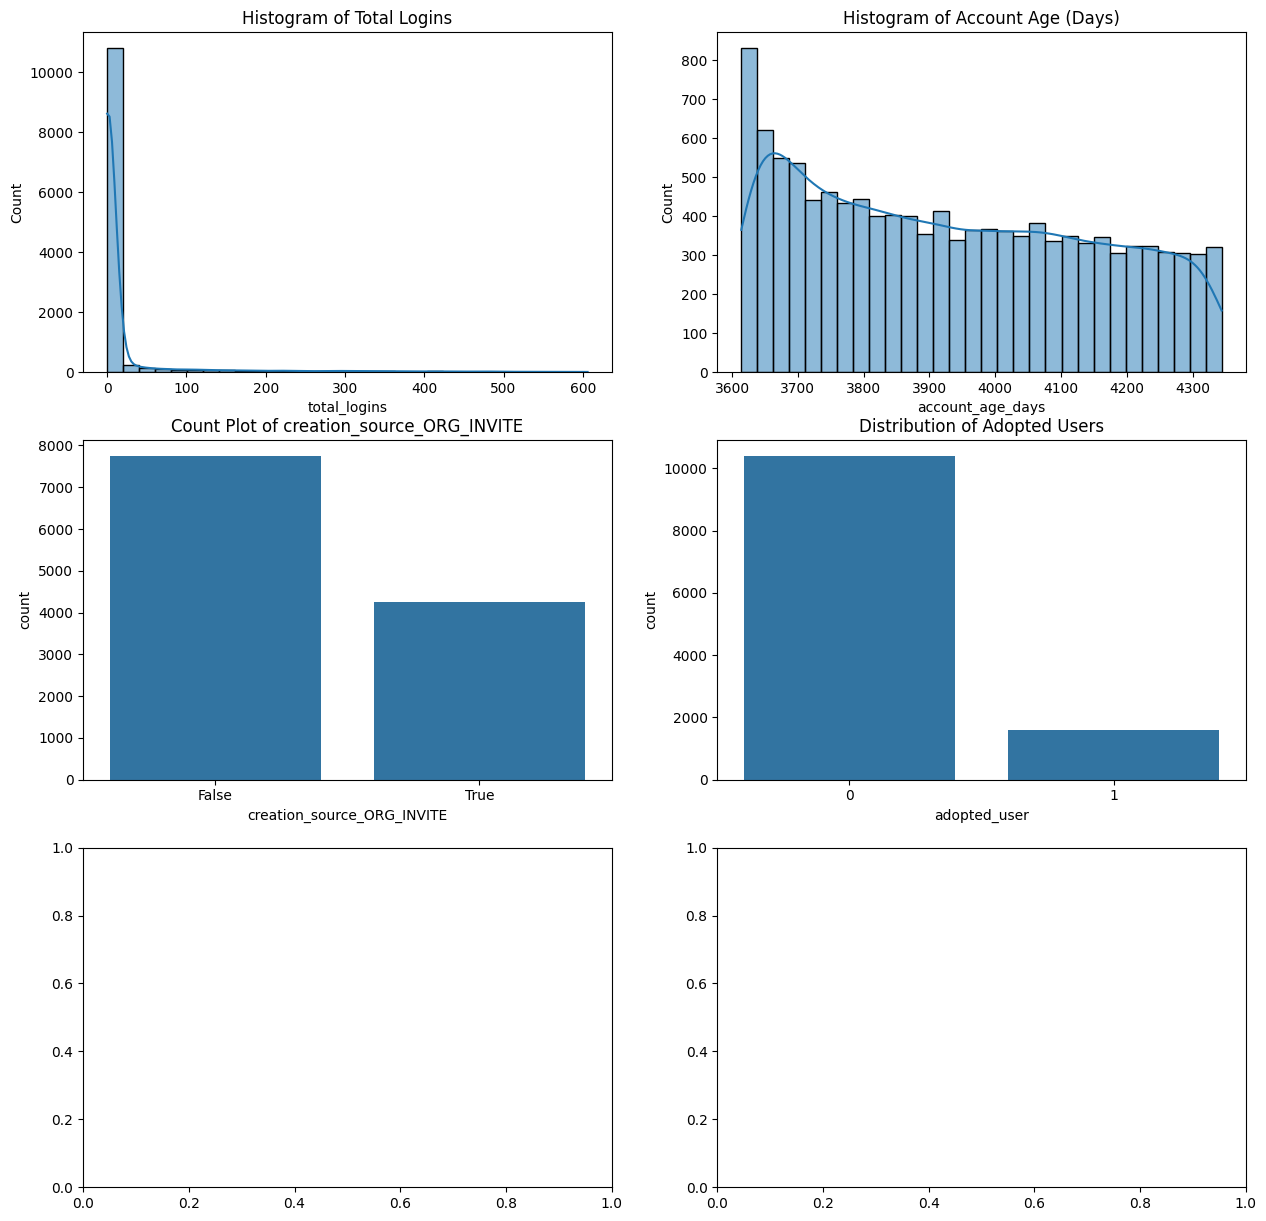

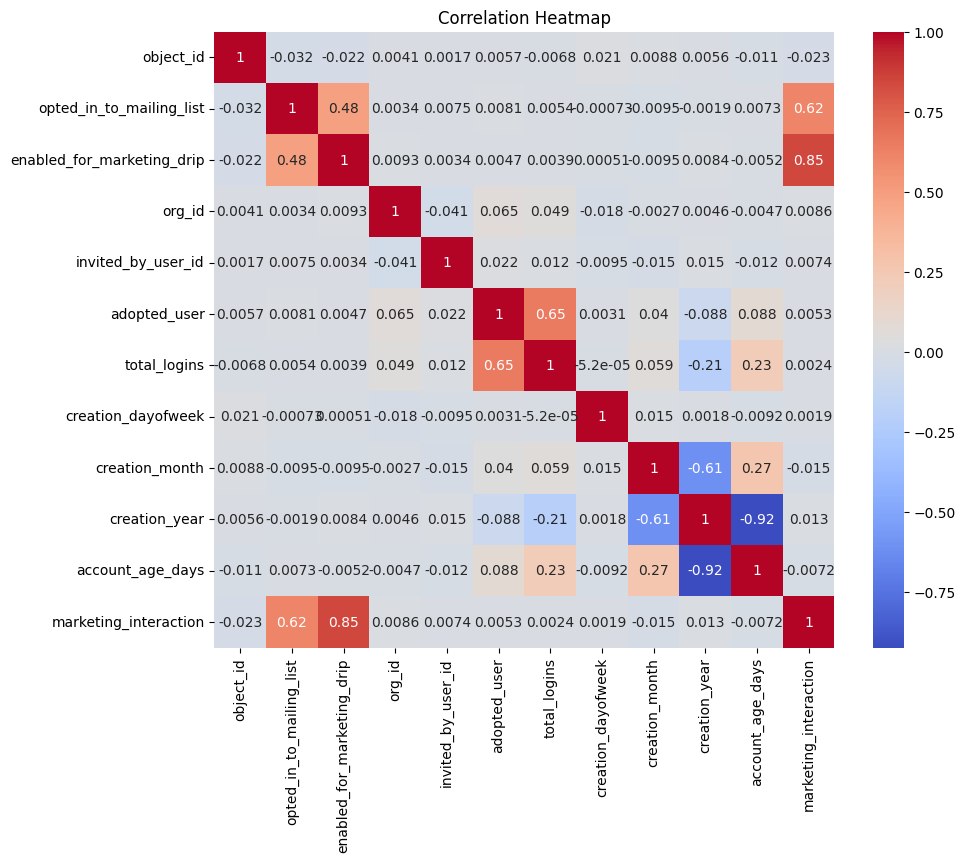

Feature Importances: [3.84478856e-03 1.54121723e-05 8.63452085e-06 3.23388525e-03
 2.85161249e-03 9.79265421e-01 3.46181412e-04 1.42054842e-03
 8.55740815e-05 8.85620766e-03 7.17346170e-05]


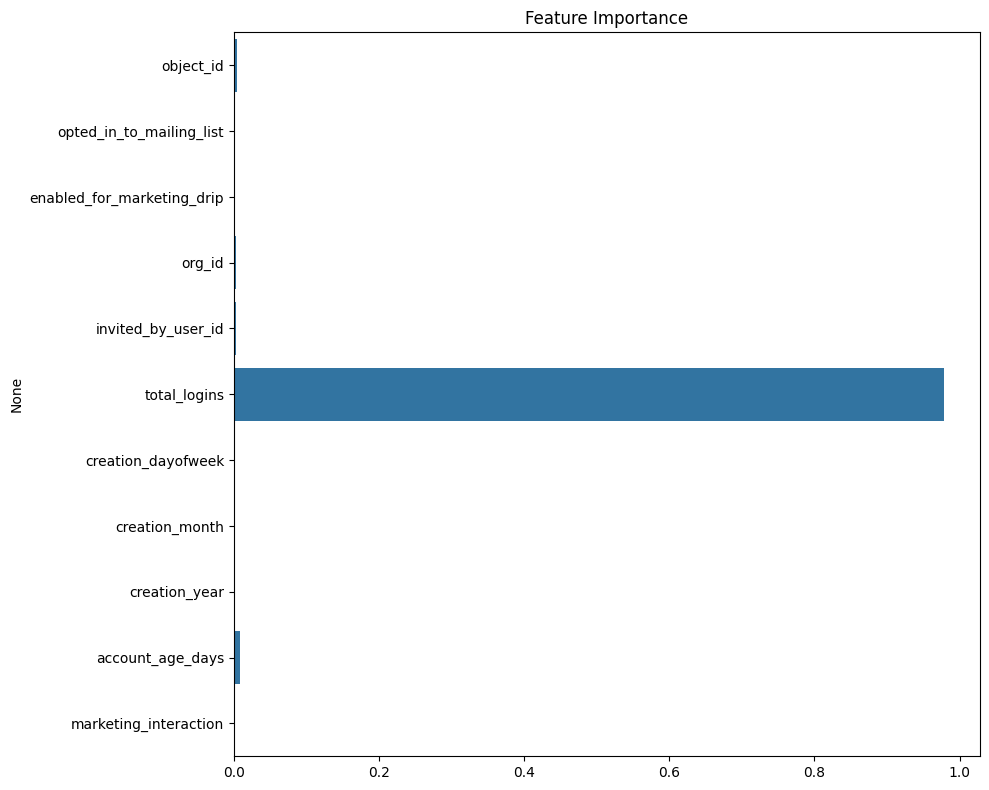

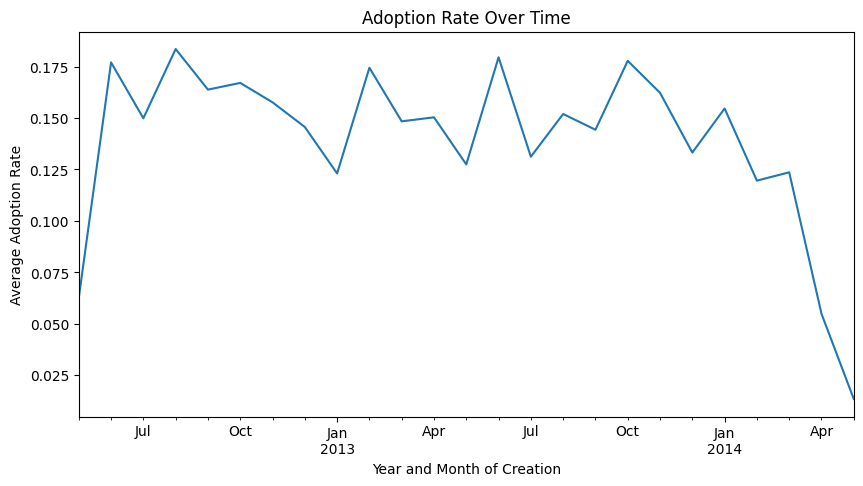

Data saved to CSV at: final_users_data.csv
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best cross-validation score: 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2593
           1       0.95      0.93      0.94       407

    accuracy                           0.98      3000
   macro avg       0.97      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load the data
users = pd.read_csv('takehome_users_2.csv', encoding='latin-1')
user_engagement = pd.read_csv('takehome_user_engagement_1.csv', encoding='latin-1')

# Convert timestamps to datetime objects
users['creation_time'] = pd.to_datetime(users['creation_time'])
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

# Identify adopted users
def identify_adopted_users(df):
    df['visited'] = 1
    df = df.set_index('time_stamp')
    adopted = df.groupby('user_id').rolling('7D').visited.count()
    adopted = adopted[adopted >= 3].reset_index()
    return adopted['user_id'].unique()

adopted_users = identify_adopted_users(user_engagement)
users['adopted_user'] = users['object_id'].isin(adopted_users).astype(int)

# Aggregating engagement data
engagement_summary = user_engagement.groupby('user_id').agg({'time_stamp': ['min', 'max', 'count']})
engagement_summary.columns = ['first_login', 'last_login', 'total_logins']
engagement_summary.reset_index(inplace=True)

# Merge the engagement summary with the users table
users = users.merge(engagement_summary, how='left', left_on='object_id', right_on='user_id')

# Drop the extra user_id column from engagement summary
users.drop(['user_id'], axis=1, inplace=True)

# Fill NaN values for numerical processing
users.fillna(0, inplace=True)

# Feature Engineering
users['creation_dayofweek'] = pd.to_datetime(users['creation_time']).dt.dayofweek
users['creation_month'] = pd.to_datetime(users['creation_time']).dt.month
users['creation_year'] = pd.to_datetime(users['creation_time']).dt.year
users['account_age_days'] = (pd.to_datetime('today') - pd.to_datetime(users['creation_time'])).dt.days
users['marketing_interaction'] = users['opted_in_to_mailing_list'] * users['enabled_for_marketing_drip']
users = pd.get_dummies(users, columns=['creation_source'], drop_first=True)

# Prepare data for modeling
X = users.select_dtypes(include=[np.number]).drop(['adopted_user'], axis=1)
y = users['adopted_user']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# machine learning pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('classifier', GradientBoostingClassifier(random_state=42))])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)

# Visualizations
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Histograms for numerical data
sns.histplot(users['total_logins'], bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Histogram of Total Logins')

sns.histplot(users['account_age_days'], bins=30, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Histogram of Account Age (Days)')

# Bar plot for categorical data
sns.countplot(x='creation_source_ORG_INVITE', data=users, ax=axs[1, 0])
axs[1, 0].set_title('Count Plot of creation_source_ORG_INVITE')

sns.countplot(x='adopted_user', data=users, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of Adopted Users')

# Correlation heatmap
non_numeric_columns = users.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)
numeric_data = users.select_dtypes(include=[np.number])
corr = numeric_data.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Correlation Heatmap')
plt.show()


# Feature Importance
feature_importance = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
print("Feature Importances:", feature_importance)

# Check if any feature importance is significantly different from zero
if np.any(feature_importance):
    # Plotting the feature importances
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(x=feature_importance, y=X.columns, ax=ax)
    ax.set_title('Feature Importance')
    plt.tight_layout()
    plt.show()
else:
    print("No significant feature importances to display.")

# User Adoption Over Time
users['creation_year_month'] = users['creation_time'].dt.to_period('M')
adoption_over_time = users.groupby('creation_year_month')['adopted_user'].mean()
plt.figure(figsize=(10, 5))
adoption_over_time.plot(title='Adoption Rate Over Time')
plt.xlabel('Year and Month of Creation')
plt.ylabel('Average Adoption Rate')
plt.show()

# Save final data to CSV
output_file_path = 'final_users_data.csv'
users.to_csv(output_file_path, index=False)
print(f"Data saved to CSV at: {output_file_path}")

# results
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
predictions = grid_search.predict(X_test)
print(classification_report(y_test, predictions))
